### Analyse the accuracies

In [1]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

import seaborn as sns
from IPython.display import display, Markdown

<h3> Dictionary for each dataset to its txt file path 

In [2]:
experiment_to_results_path = {
    "bitcoinOTC"    : r'stats/fl_lp/bitcoinOTC_1.txt',
    "UCI"           : r'stats/fl_lp/UCI_1.txt',
    "UCI_no_sharing": r'stats/fl_lp/No_Sharing.txt',
    "UCI_unbalanced": r'stats/fl_lp/Unbalanced.txt',
    "DBLP3"       : r'stats/fl_nc/DBLP3.txt',
    "DBLP3_2"       : r'stats/fl_nc/DBLP3_2.txt',
    "Metis_DBLP3"   : r'stats/fl_nc/Metis_DBLP3.txt',
    "Metis_DBLP5"   : r'stats/fl_nc/Metis_DBLP5.txt',
    "Reddit"        : r'stats/fl_nc/Reddit_1.txt',
    "FedGCN"        : r'stats/fl_lp/FedGCN.txt',
    "DBLP5"       : r'stats/fl_nc/DBLP5_1.txt',
    "DBLP5_Unbalanced": r'stats/fl_nc/Unbalanced.txt',
    "UCI_Metis"     : r'stats/fl_lp/Metis_UCI.txt',
    "Reddit_MinCutFirst": r'stats/gpa/20250716/Reddit_Full/mincut_primary.txt',
    "Reddit_BalanceFirst": r'stats/gpa/20250716/Reddit_Full/balance_primary.txt',
    "Reddit_LabelFirst": r'stats/gpa/20250716/Reddit_Full/label_primary.txt',
    "UCI_MinCutFirst": r'stats/gpa/20250716/UCI_Full/mincut_primary.txt',
    "UCI_BalanceFirst": r'stats/gpa/20250716/UCI_Full/balance_primary.txt',
    "DBLP3_MinCutFirst": r'stats/gpa/20250716/DBLP3_Full/mincut_primary.txt',
    "DBLP3_BalanceFirst": r'stats/gpa/20250716/DBLP3_Full/balance_primary.txt',
    "DBLP3_LabelFirst": r'stats/gpa/20250716/DBLP3_Full/label_primary.txt',
    "DBLP5_MinCutFirst": r'stats/gpa/20250716/DBLP5_Full/mincut_primary.txt',
    "DBLP5_BalanceFirst": r'stats/gpa/20250716/DBLP5_Full/balance_primary.txt',
    "DBLP5_LabelFirst": r'stats/gpa/20250716/DBLP5_Full/label_primary.txt',
}
DATASET = "Reddit_MinCutFirst"

<h3> Function to parse each of the txt files that we ran to extract results

In [3]:
def parse_log_file(file_path):
    snapshot_to_local_accs = defaultdict(list)
    snapshot_to_global_accs = defaultdict(list)
    snapshot_aggregated_test_accs = defaultdict(list)
    snapshot_to_class_distribution = {}
    snapshot_to_best_round_metrics = {}
    snapshot_to_subgraph_num_and_distribution = {}

    snapshot_to_cut_edges = defaultdict(int)
    snapshot_to_edges = defaultdict(int)
    with open(file_path, 'r') as f:
        snapshot = None
        curr_local_list = []
        aggre_test_accs = []
        for line in f:
            snapshot_num_search = re.search(r"Snapshot (\d+)", line)
            if snapshot_num_search is not None:
                snapshot = int(snapshot_num_search.group(1))

            if '@Cloud> accuracy' in line:
                round_global_acc = re.search(r"accuracy\s*=\s*([+-]?\d*\.\d+)", line)
                if round_global_acc is not None:
                    global_acc = float(round_global_acc.group(1))
                    snapshot_to_global_accs[snapshot].append(global_acc)


            if '@Local> accuracy' in line:
                snapshot_match_list = re.search(r"\[(.*?)\]", line)
                if snapshot_match_list is not None:
                    curr_local_list.append([float(i) for i in snapshot_match_list.group(1).split(', ') if float(i) > 0])
            else:
                if curr_local_list != []:
                    snapshot_to_local_accs[snapshot].append(curr_local_list)
                    curr_local_list = []
                    
            if "Test Accuracy is" in line:
                snapshot_test_acc_match = re.search(r"Test Accuracy is (\d+\.\d+)", line)
                if snapshot_test_acc_match is not None:
                    aggre_test_accs.append(float(snapshot_test_acc_match.group(1)))
            else:
                if aggre_test_accs != []:
                    snapshot_aggregated_test_accs[snapshot].append(aggre_test_accs)
                    aggre_test_accs = []

            if "Subgraph" in line:
                subgraph_dict_match = re.search(r"Subgraph\s+(\d+):\s+(\{(?:\s*\d+\s*:\s*\d+\s*,?)+\})", line)
                if subgraph_dict_match is not None:
                    if snapshot not in snapshot_to_class_distribution:
                        snapshot_to_class_distribution[snapshot] = {}
                    snapshot_to_class_distribution[snapshot].update({int(subgraph_dict_match.group(1)):eval(subgraph_dict_match.group(2))})

            if "Best Round" in line:
                best_line_match = re.search(r"defaultdict\(None, ({.*})\)", line)
                if best_line_match is not None:
                    snapshot_to_best_round_metrics[snapshot] = eval(best_line_match[1])

            if "Client" in line and "training" in line:
                client_edges_line_match = re.search(r"Client (\d+) has (\d+) positive training edges", line)
                if client_edges_line_match is not None:
                    if snapshot not in snapshot_to_subgraph_num_and_distribution:
                        snapshot_to_subgraph_num_and_distribution[snapshot] = {}
                    snapshot_to_subgraph_num_and_distribution[snapshot].update({int(client_edges_line_match.group(1)):int(client_edges_line_match.group(2))})

            if "cut edges" in line:
                cut_edge_match = re.search(r"Total number of cut edges: (\d+)", line)
                if cut_edge_match is not None:
                    snapshot_to_cut_edges[snapshot] = int(cut_edge_match.group(1))

            if "A total" in line:
                edges_match = re.search(r"A total of (\d+) training edges", line)
                if edges_match is not None:
                    snapshot_to_edges[snapshot] = int(edges_match.group(1))

    return snapshot_to_local_accs, snapshot_to_global_accs, \
        snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
        snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
        snapshot_to_cut_edges, snapshot_to_edges

snapshot_to_local_accs, snapshot_to_global_accs, \
snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
snapshot_to_cut_edges, snapshot_to_edges\
    = parse_log_file(experiment_to_results_path[DATASET])

<h3> Multi Index Pandas DataFrame to Present all of the Metrics for the given Dataset

In [ ]:
def get_metrics(snapshot_to_best_round_metrics, dataset):
    # Convert the dictionary to a pandas DataFrame
    df = pd.DataFrame(snapshot_to_best_round_metrics).T  # Transpose to have the keys (0, 1, 2, ...) as rows

    # Calculate the average for each column (excluding the 'best_round' column if it's categorical)
    averages = df.drop(columns='best_round').mean(axis=0)

    # Add a new row for the averages
    df.loc['Average'] = averages

    display(Markdown(f"<h2> Dataset Values for {dataset}"))
    # Display the DataFrame
    display(df)

In [ ]:
# DATASET = "FedGCN" # NOTE: For Quick Dataset Change
# snapshot_to_local_accs, snapshot_to_global_accs, \
#     snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
#     snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution\
#         = parse_log_file(experiment_to_results_path[DATASET])
get_metrics(snapshot_to_best_round_metrics, DATASET)

In [ ]:
snapshot_to_global_accs
overall_avg = 0
count = 0
for snapshot, accs in snapshot_to_global_accs.items():
    for acc in accs:
        overall_avg += acc
        count += 1

print(overall_avg/count)

<h3> Analyising the Convergence of Local Client Accuracy over Given Rounds

In [ ]:
def remove_outliers(values):
    # Calculate the first and third quartiles (Q1, Q3)
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter values within the range
    filtered_values = [value for value in values if lower_bound <= value <= upper_bound]
    
    return filtered_values


def plot_convergence_of_local_accuracies(snapshot_to_local_accs, snapshots, dataset):
    # Set Seaborn style for better aesthetics
    sns.set(style="whitegrid", palette="colorblind")  # You can choose different palettes too
    
    # Increase figure size
    plt.figure(figsize=(18, 12))  
    
    # Generate distinct base colors for each snapshot
    base_colors = sns.color_palette("husl", len(snapshots))  # Ensure distinct colors for snapshots

    # List to store legend labels for sorting
    legend_labels = []
    legend_handles = []
    
    # Loop over snapshots
    for snapshot_idx, snapshot in enumerate(snapshots):
        snapshot_x_vals = []  # x values for this snapshot
        snapshot_y_vals = []  # y values for this snapshot
        snapshot_count = 0  # Counter to track the number of epochs for this snapshot
        
        # Loop over rounds in the snapshot
        for round in range(len(snapshot_to_local_accs[snapshot][:99])):
            client_acc_sum = [0 for _ in range(len(snapshot_to_local_accs[snapshot][round][0]))]
            
            for local_accs_round in snapshot_to_local_accs[snapshot][round]:
                
                client_acc_sum[0] += sum(local_accs_round) / len(local_accs_round)
                snapshot_count += 1
                
            client_acc_avgs = [client_acc_sum[i] / len(snapshot_to_local_accs[snapshot][round]) for i in range(len(client_acc_sum)) if client_acc_sum[i] > 0]
            
            # Add to snapshot-specific lists
            snapshot_x_vals.append(snapshot_count)  # Store x value (epoch)
            snapshot_y_vals.append(client_acc_avgs)  # Store y value (accuracy)
            
            # Plot vertical lines every 10 epochs
            if snapshot_count % 10 == 0:
                plt.axvline(snapshot_count/10, color='gray', linestyle='--', alpha=0.5)
        
        # Average over every 10 epochs
        averaged_x_vals = []
        averaged_y_vals = []
        
        # Group by every 10 epochs for averaging
        for i in range(0, len(snapshot_x_vals), 10):
            avg_x = snapshot_x_vals[i:i+10]
            avg_y = snapshot_y_vals[i:i+10]
            
            # Average the y values (accuracy) over every 10 epochs
            avg_accuracy = [sum(acc) / len(acc) for acc in zip(*avg_y)]
            
            # The x value will be the last epoch in each 10-epoch block, divided by 10
            averaged_x_vals.append(avg_x[-1] / 10)  # Divide by 10
            
            averaged_y_vals.append(avg_accuracy)
        
        # Generate slightly darker shades for clients using the base color
        color_shades = sns.light_palette(base_colors[snapshot_idx], n_colors=len(averaged_y_vals), reverse=True)  # Slightly darker shades
        
        # Plot each client's line with a different shade
        for client_idx in range(len(averaged_y_vals[0])):
            y_vals_filtered = [averaged_y_vals[row][client_idx] for row in range(len(averaged_y_vals))]

            # Plot each line with a different shade
            line = sns.lineplot(x=averaged_x_vals, 
                                y=y_vals_filtered, 
                                label=f"Snapshot {snapshot_idx + 1}", 
                                marker='o', 
                                linewidth=2, 
                                color=color_shades[client_idx])

            # Collect the legend handles and labels
            legend_labels.append(line.get_label())
            legend_handles.append(line)

            # Add a vertical line for each x point
            for x_val in averaged_x_vals:
                plt.axvline(x=x_val, color='gray', linestyle='-', alpha=0.3)  # Multiply by 10 to get the original x value scale
        
    # Finalize the plot with Seaborn styling
    plt.xlabel('Round Number', fontsize=23)
    plt.ylabel('Avg Accuracy per Round', fontsize=25)
    plt.title(f'Rounds of Convergence for Final Snapshot for {dataset}', fontsize=30, fontweight="bold")
    
    plt.ylim(0.0, 1.0)  # Y-axis between 0 and 1
    
    # Adjust the x-axis range based on the new scale
    plt.xlim(1, max(averaged_x_vals) )  # Adjust x-axis to show original epoch scale
    
    # Legend at the bottom with grouped labels
    plt.legend(title="Clients", loc='upper center', bbox_to_anchor=(0.5, -0.05), 
               ncol=5, fontsize=12, frameon=False)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [ ]:
# DATASET = "DBLP5" # NOTE: For Quick Dataset Change
# snapshot_to_local_accs, snapshot_to_global_accs, \
#     snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
#     snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
#     snapshot_to_cut_edges, snapshot_to_edges\
#         = parse_log_file(experiment_to_results_path[DATASET])
plot_convergence_of_local_accuracies(snapshot_to_local_accs, list(snapshot_to_local_accs.keys()), DATASET)

### Plotting each clients' local accuracies in all snapshots

In [ ]:
# WRONG, NEED TO CHANGE

def plot_local_accur_over_snapshots(snapshot_to_local_accs):
    # Set up Seaborn styling
    sns.set(style="whitegrid", palette="colorblind")

    # Snapshot IDs
    snapshots = list(snapshot_to_local_accs.keys())
    num_snapshots = len(snapshots)
    n_cols = 2
    n_rows = (num_snapshots + n_cols - 1) // n_cols

    # Create grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows), sharey=True)

    # Normalize axes list
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Plot each snapshot
    for idx, snapshot in enumerate(snapshots):
        ax = axes[idx]
        for rd in snapshot_to_local_accs[snapshot]:
            client_accs = {}  
            for client_idx, acc in enumerate(rd[0]):
                if client_idx not in client_accs:
                    client_accs[client_idx] = [acc]
                else:
                    client_accs[client_idx].append(acc)
                print(client_accs)
                # client_accs = [round[client_idx] for round in rounds]
                # ax.plot(range(1, num_rounds + 1), client_accs, marker='o', label=f'Client {client_idx + 1}')

        ax.set_title(f'Snapshot {snapshot}', fontsize=16)
        ax.set_xlabel('Round Number', fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)
        ax.set_ylim(0, 1.0)
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(True)

    # Remove unused subplots
    for j in range(len(snapshots), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Local Client Accuracy Over Rounds Per Snapshot', fontsize=20, y=0.95)
    plt.tight_layout()
    plt.show()


<h3> Take a look at the Global Accuracy over Snapshots

In [ ]:
# DATASET = "DBLP3_2" # NOTE: For Quick Dataset Change
# snapshot_to_local_accs, snapshot_to_global_accs, \
#     snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
#     snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution\
#         = parse_log_file(experiment_to_results_path[DATASET])


modified_dict = {} # plot_convergence_of_local_accuracies
for snapshot in snapshot_to_global_accs:
    modified_dict[snapshot] = [[[i] for i in snapshot_to_global_accs[snapshot]]]
# plot_convergence_of_local_accuracies(modified_dict, modified_dict.keys(), DATASET)

In [ ]:
def plot_global_accuracy(snapshot_data):
    # Step 1: Flatten all values and track boundaries
    all_values = []
    snapshot_start_indices = []
    index = 0

    for snapshot_id in sorted(snapshot_data.keys()):
        rounds = snapshot_data[snapshot_id][0]
        snapshot_start_indices.append(index)
        for item in rounds:
            all_values.append(item[0])
            index += 1

    # Step 2: Plot the line with snapshot markers
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(all_values)+1), all_values, marker='o', label="Values")

    # Add vertical lines for snapshot boundaries
    for i, snapshot_start in enumerate(snapshot_start_indices):
        if snapshot_start > 0:
            plt.axvline(snapshot_start + 1, color='gray', linestyle='--', alpha=0.6)
            plt.text(snapshot_start + 1.1, max(all_values), f"Snapshot {i}", rotation=90,
                    verticalalignment='bottom', fontsize=10, color='gray')

    # Labels and title
    plt.xlabel("Rounds")
    plt.ylabel("Value")
    plt.title("Global Accuracy over Snapshots")
    plt.grid(False)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [ ]:
plot_global_accuracy(modified_dict)

## Extracting the Node Class Distributions for Node Classification Tasks

In [4]:
def get_multi_index_table_for_label_distribution(snapshot_to_class_distribution):
    df = pd.DataFrame.from_dict(
        {(outer_k, inner_k): values for outer_k, inner_dict in snapshot_to_class_distribution.items() for inner_k, values in inner_dict.items()},
        orient='index'
    )

    # Set MultiIndex
    df.index = pd.MultiIndex.from_tuples(df.index, names=["Snapshot", "Class Labels"]).T

    # Transpose the DataFrame
    df_transposed = df.T

    # Show all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    # df_transposed.to_csv("output.csv")
    return df_transposed

In [6]:
# # DATASET = "" # NOTE: For Quick Dataset Change
# snapshot_to_local_accs, snapshot_to_global_accs, \
#     snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
#     snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
#     snapshot_to_cut_edges, snapshot_to_edges\
#         = parse_log_file(experiment_to_results_path[DATASET])
get_multi_index_table_for_label_distribution(snapshot_to_class_distribution)

Snapshot        0                                               1            \
Class Labels    0    1    2    3    4    5    6    8       9    0    1    2   
0             4.0  2.0  3.0  1.0  1.0  3.0  3.0  6.0  2049.0  4.0  2.0  3.0   
1             4.0  1.0  1.0  NaN  2.0  3.0  1.0  6.0  2051.0  4.0  1.0  1.0   
2             3.0  NaN  NaN  NaN  2.0  2.0  2.0  4.0  2062.0  3.0  NaN  NaN   
3             2.0  NaN  NaN  2.0  1.0  NaN  1.0  2.0  2064.0  2.0  NaN  NaN   

Snapshot                                         2                           \
Class Labels    3    4    5    6    8       9    0    1    2    3    4    5   
0             1.0  1.0  3.0  3.0  6.0  2049.0  4.0  2.0  3.0  1.0  1.0  3.0   
1             NaN  2.0  3.0  1.0  6.0  2051.0  4.0  1.0  1.0  NaN  2.0  3.0   
2             NaN  2.0  2.0  2.0  4.0  2062.0  3.0  NaN  NaN  NaN  2.0  2.0   
3             2.0  1.0  NaN  1.0  2.0  2064.0  2.0  NaN  NaN  2.0  1.0  NaN   

Snapshot                          3                                     \
Class Labels    6    8       9    0    1    2    3    4    5    6    8   
0             3.0  6.0  2049.0  4.0  2.0  3.0  1.0  1.0  3.0  3.0  6.0   
1             1.0  6.0  2051.0  4.0  1.0  1.0  NaN  2.0  3.0  1.0  6.0   
2             2.0  4.0  2062.0  3.0  NaN  NaN  NaN  2.0  2.0  2.0  4.0   
3             1.0  2.0  2064.0  2.0  NaN  NaN  2.0  1.0  NaN  1.0  2.0   

Snapshot                4                                               5  \
Class Labels       9    0    1    2    3    4    5    6    8       9    0   
0             2049.0  4.0  2.0  3.0  1.0  1.0  3.0  3.0  6.0  2049.0  4.0   
1             2051.0  4.0  1.0  1.0  NaN  2.0  3.0  1.0  6.0  2051.0  4.0   
2             2062.0  3.0  NaN  NaN  NaN  2.0  2.0  2.0  4.0  2062.0  3.0   
3             2064.0  2.0  NaN  NaN  2.0  1.0  NaN  1.0  2.0  2064.0  2.0   

Snapshot                                                   6                 \
Class Labels    1    2    3    4    5    6    8       9    0    1    2    3   
0             2.0  3.0  1.0  1.0  3.0  3.0  6.0  2049.0  4.0  2.0  3.0  1.0   
1             1.0  1.0  NaN  2.0  3.0  1.0  6.0  2051.0  4.0  1.0  1.0  NaN   
2             NaN  NaN  NaN  2.0  2.0  2.0  4.0  2062.0  3.0  NaN  NaN  NaN   
3             NaN  NaN  2.0  1.0  NaN  1.0  2.0  2064.0  2.0  NaN  NaN  2.0   

Snapshot                                    7                                \
Class Labels    4    5    6    8       9    0    1    2    3    4    5    6   
0             1.0  3.0  3.0  6.0  2049.0  4.0  2.0  3.0  1.0  1.0  3.0  3.0   
1             2.0  3.0  1.0  6.0  2051.0  4.0  1.0  1.0  NaN  2.0  3.0  1.0   
2             2.0  2.0  2.0  4.0  2062.0  3.0  NaN  NaN  NaN  2.0  2.0  2.0   
3             1.0  NaN  1.0  2.0  2064.0  2.0  NaN  NaN  2.0  1.0  NaN  1.0   

Snapshot                     0    1    2    3    4    5    6    7  
Class Labels    8       9    7    7    7    7    7    7    7    7  
0             6.0  2049.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1             6.0  2051.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2             4.0  2062.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  
3             2.0  2064.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [7]:
def plot_multiindex_nested_dict(data, dataset):
    """
    Converts a nested dictionary into a MultiIndex Pandas DataFrame 
    and plots a stacked bar chart using Seaborn with percentage labels.
    
    Parameters:
        data (dict): The nested dictionary.
    """
    # Apply Seaborn's modern style
    sns.set_style("whitegrid")

    # Step 1: Convert the Nested Dict into a MultiIndex DataFrame
    records = []
    for outer_key, sub_dict in data.items():
        for inner_key, inner_values in sub_dict.items():
            total = sum(inner_values.values())
            proportions = {k: v / total if total > 0 else 0 for k, v in inner_values.items()}
            records.append((outer_key, inner_key, *proportions.values()))

    # Extract unique categories dynamically
    all_categories = sorted({k for sub_dict in data.values() for inner_dict in sub_dict.values() for k in inner_dict})

    # Create DataFrame
    df = pd.DataFrame(records, columns=["Outer Key", "Inner Key"] + all_categories)
    df.set_index(["Outer Key", "Inner Key"], inplace=True)  # MultiIndex

    # Step 2: Create a Matplotlib Figure
    fig, ax = plt.subplots(figsize=(25, 15))  # Extra-wide figure for more spacing
    
    # Use a fun, vibrant color palette
    colors = sns.color_palette("pastel", n_colors=len(df.columns))  # Bright pastel colors 🌈

    # Step 3: Plot Stacked Bar Chart
    indices = np.arange(len(df))
    bar_width = 1.0  # Adjusted bar width to give enough space
    bottoms = np.zeros(len(df))  # Track bottom position for stacking
    bars = []
    
    for i, category in enumerate(df.columns):
        bars.append(ax.bar(indices, df[category], bottom=bottoms, color=colors[i], label=f"Node label {category}", edgecolor="black", width=bar_width))
        bottoms += df[category]  # Update bottom for stacking

    # Step 4: Add Percentage Labels on Bars Vertically without Background Box
    for i, bar_group in enumerate(bars):  # Loop through each category's bars
        for rect in bar_group:  # Each individual bar
            height = rect.get_height()
            if height > 0.02:  # Avoid cluttering very small values
                x = rect.get_x() + rect.get_width() / 2
                y = rect.get_y() + height / 2
                ax.text(x, y, f"{height * 100:.1f}%", ha="center", va="center", 
                        fontsize=10, color="black", fontweight="bold")

    # Step 5: Add Red Vertical Lines when the First Number of x-axis Changes
    # Extract the first numbers of the x-axis labels
    outer_keys = [f"{i[0]}-{i[1]}" for i in df.index]
    last_outer_key = None
    for idx, outer_key in enumerate(outer_keys):
        first_number = outer_key.split('-')[0]  # Get the first part (before '-')
        if last_outer_key is not None and first_number != last_outer_key:
            # Draw a thick red line
            ax.axvline(x=idx - 0.5, color='white', linewidth=10)
        last_outer_key = first_number
    ax.axvline(x=len(outer_keys)+0.5, color='white', linewidth=10)
    # Step 6: Customize the Plot with a Happier Vibe ✨
    ax.set_xlabel("Snapshot - Client", fontsize=20, fontweight="bold", labelpad=12)
    ax.set_ylabel("Proportion of Nodes", fontsize=20, fontweight="bold", labelpad=12)
    ax.set_title(f"Snapshot to Client Partitioning Class Distribution for {dataset}", fontsize=40, fontweight="bold", pad=15)
    ax.set_xticks(indices)
    ax.set_xticklabels(outer_keys, rotation=45, ha="right", fontsize=12, fontweight="bold")
    
    # Add subtle grid lines
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)

    # Set dynamic y-limit to ensure no bars are squished
    ax.set_ylim(0, 1.0)  # Give some space above 100% for clarity

    # Add a clean legend with a border
    legend = ax.legend(title="Class Distribution", fontsize=12, title_fontsize=14, loc="upper left", bbox_to_anchor=(1, 1))
    legend.get_frame().set_edgecolor("black")  # Add border to legend

    plt.tight_layout()
    plt.show()


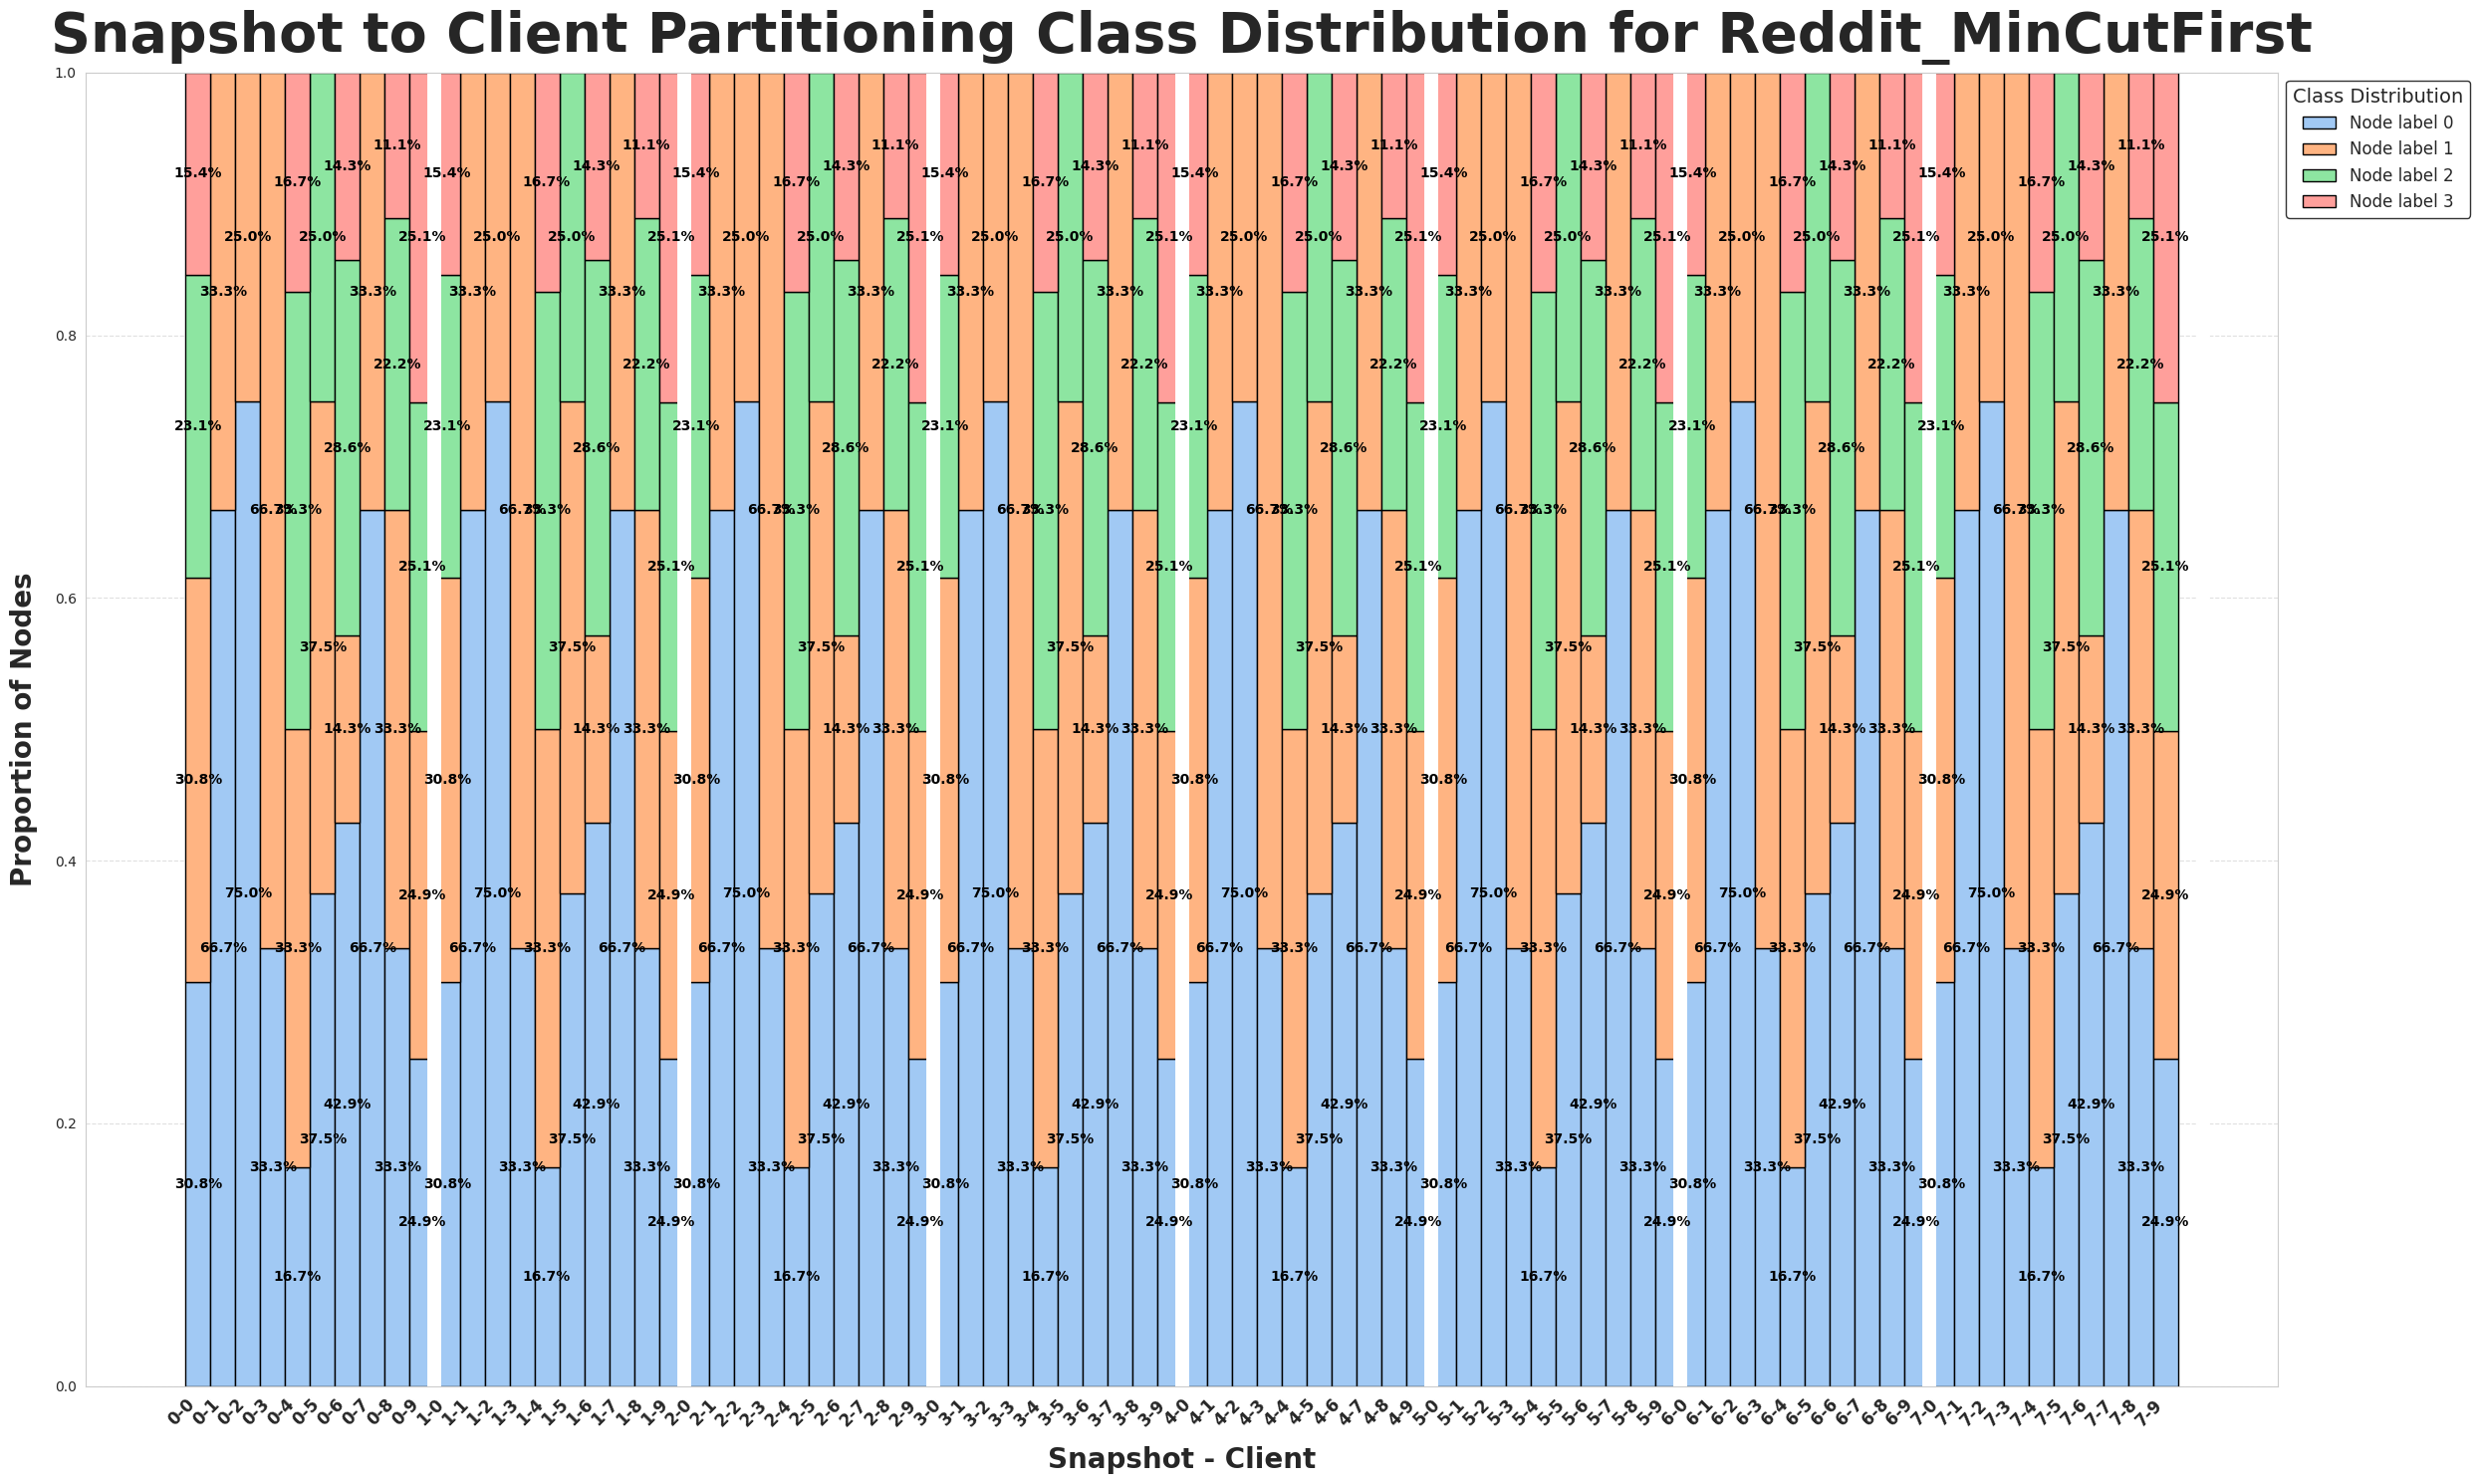

In [8]:
# DATASET = "DBLP5" # NOTE: For Quick Dataset Change
# snapshot_to_local_accs, snapshot_to_global_accs, \
#     snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
#     snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
#     snapshot_to_cut_edges, snapshot_to_edges\
#         = parse_log_file(experiment_to_results_path[DATASET])

# Example Usage
plot_multiindex_nested_dict(snapshot_to_class_distribution, DATASET)

### Calculate Shannon Entropy for Label Diversity

{0: {0: {0: 169, 1: 44, 2: 1, 3: 18}, 1: {0: 92, 1: 17, 2: 5, 3: 49, 4: 20}, 2: {0: 1451, 1: 1024, 2: 1043, 3: 1232, 4: 660}, 3: {0: 229, 1: 100, 2: 9, 3: 38, 4: 16}, 4: {0: 245, 1: 99, 2: 8, 3: 32, 4: 5}}, 1: {0: {0: 168, 1: 51, 2: 1, 3: 21, 4: 5}, 1: {0: 126, 1: 10, 2: 6, 3: 44, 4: 15}, 2: {0: 211, 1: 30, 2: 6, 3: 59, 4: 13}, 3: {0: 248, 1: 84, 2: 7, 3: 30, 4: 4}, 4: {0: 1269, 1: 1082, 2: 1042, 3: 1184, 4: 660}, 5: {0: 164, 1: 27, 2: 4, 3: 31, 4: 4}}, 2: {0: {0: 194, 1: 51, 2: 3, 3: 31, 4: 4}, 1: {0: 87, 1: 5, 2: 2, 3: 8, 4: 4}, 2: {0: 252, 1: 31, 2: 6, 3: 57, 4: 18}, 3: {0: 143, 1: 51, 2: 7, 3: 27, 4: 19}, 4: {0: 1270, 1: 1095, 2: 1040, 3: 1183, 4: 641}, 5: {0: 126, 1: 7, 2: 6, 3: 40, 4: 10}, 6: {0: 114, 1: 44, 2: 2, 3: 23, 4: 5}}, 3: {0: {0: 201, 1: 30, 2: 5, 3: 21, 4: 4}, 1: {0: 77, 1: 22, 2: 2, 3: 7, 4: 4}, 2: {0: 959, 1: 1005, 2: 1027, 3: 1165, 4: 645}, 3: {0: 169, 1: 15, 2: 5, 3: 56, 4: 17}, 4: {0: 276, 1: 73, 2: 9, 3: 46, 4: 8}, 5: {0: 196, 1: 63, 2: 3, 3: 31, 4: 3}, 6: {0: 14

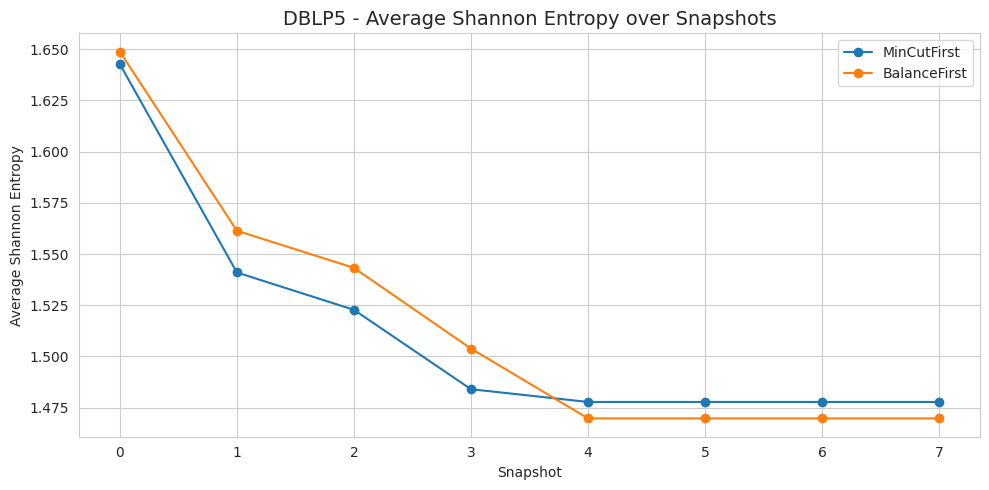

In [18]:
def compute_shannon_entropy(label_counts: dict) -> float:
    total = sum(label_counts.values())
    if total == 0:
        return 0.0
    probs = np.array([count / total for count in label_counts.values()])
    return -np.sum(probs * np.log2(probs + 1e-12))  # small epsilon to prevent log(0)

def compute_snapshot_entropy(snapshot_to_class_distribution):
    snapshot_entropy = {}
    for snapshot, subgraph_label_dict in snapshot_to_class_distribution.items():
        entropies = []
        for subgraph, label_dist in subgraph_label_dict.items():
            entropy = compute_shannon_entropy(label_dist)
            entropies.append(entropy)
        if entropies:
            snapshot_entropy[snapshot] = np.mean(entropies)
        else:
            snapshot_entropy[snapshot] = 0.0
    return snapshot_entropy

def plot_entropy_across_snapshots(strategy_to_entropy_dict, dataset=""):
    plt.figure(figsize=(10, 5))
    for strategy, entropy_dict in strategy_to_entropy_dict.items():
        snapshots = sorted(entropy_dict.keys())
        entropy_values = [entropy_dict[s] for s in snapshots]
        plt.plot(snapshots, entropy_values, label=strategy, marker='o')

    plt.xlabel("Snapshot")
    plt.ylabel("Average Shannon Entropy")
    plt.title(f"{dataset} - Average Shannon Entropy over Snapshots", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

strategy_to_entropy = {}
for strategy, path in zip(["MinCutFirst", "BalanceFirst"],["DBLP5_MinCutFirst", "DBLP5_BalanceFirst", "DBLP5_LabelFirst"]):
    _, _, _, snapshot_to_class_distribution, *_ = parse_log_file(experiment_to_results_path[path])
    print(snapshot_to_class_distribution)
    snapshot_entropy = compute_snapshot_entropy(snapshot_to_class_distribution)
    strategy_to_entropy[strategy] = snapshot_entropy

plot_entropy_across_snapshots(strategy_to_entropy, dataset="DBLP5")

## Plot cut edges in each subgraph

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_edge(data, dataset):
    # Prepare data for plotting
    x = list(data.keys())  # X-axis (keys of the dictionary)
    num_bars = max(len(v) for v in data.values())  # Number of bars (length of the longest list)

    # Collect the values for each bar group
    values = [list(d.values()) for d in data.values()]
    
    # Pad shorter lists with 0s to match the longest one
    padded_values = [v + [0] * (num_bars - len(v)) for v in values]
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(padded_values, columns=[f'Client {i}' for i in range(num_bars)])
    df['Snapshot'] = x
    
    # Normalize the values to represent proportions
    df_proportions = df.drop(columns='Snapshot').apply(lambda x: x / x.sum(), axis=1)
    df_proportions['Snapshot'] = df['Snapshot']

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create the plot
    plt.figure(figsize=(12, 7))

    # Plot a stacked bar chart
    ax = df_proportions.set_index('Snapshot').plot(kind='bar', stacked=True, figsize=(12, 7),
                                                   colormap='viridis', width=0.8)
    plt.xlim(12,23)
    # Customize plot labels and title
    ax.set_xlabel('Snapshot Number', fontsize=12)
    ax.set_ylabel('Proportion of Edges', fontsize=12)
    ax.set_title(f'Stacked Bar Plot of Edge Distribution by Snapshot for {dataset}', fontsize=20, fontweight="bold")
    
    # Adjust the legend
    plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Tight layout
    plt.tight_layout()

    # Show plot
    plt.show()

def plot_cut_edges(data, dataset):
    # Extract the first and second elements of the tuple (cut and uncut edges)
    first_elements = [first for first, second in data.values()]  # cut edges
    second_elements = [second for first, second in data.values()]  # uncut edges

    # Prepare the x-axis (snapshot numbers)
    snapshots = list(data.keys())

    # Plotting
    sns.set(style="whitegrid")  # Set Seaborn style

    plt.figure(figsize=(10, 6))

    # Create a stacked bar plot
    bar_width = 0.8  # width of the bars
    index = np.arange(len(snapshots))  # X-axis positions

    # Plot the first (red) part of the bars (cut edges)
    plt.bar(index, first_elements, bar_width, color='red', label='Cut Edges')

    # Plot the second (blue) part of the bars (uncut edges) on top of the first
    plt.bar(index, second_elements, bar_width, bottom=first_elements, color='blue', label='Uncut Edges')

    # Customize the plot
    plt.xlabel('Snapshot Number', fontsize=12)
    plt.ylabel('Number of Edges', fontsize=12)
    plt.title(f'Cut and Uncut Edges by Snapshot for {dataset}', fontsize=17, fontweight="bold")

    # Set x-ticks to be the snapshot numbers
    plt.xticks(index, snapshots)

    # Add a legend
    plt.legend(title='Edge Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Tight layout
    plt.tight_layout()
    plt.show()

In [ ]:
# DATASET = "bitcoinOTC" # NOTE: For Quick Dataset Change
# snapshot_to_local_accs, snapshot_to_global_accs, \
#     snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
#     snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
#     snapshot_to_cut_edges, snapshot_to_edges\
#         = parse_log_file(experiment_to_results_path[DATASET])

plot_edge(snapshot_to_subgraph_num_and_distribution, DATASET)

both = defaultdict(tuple)
snapshot = 0
for cut, total in zip(snapshot_to_cut_edges.values(), snapshot_to_edges.values()):
    both[snapshot] = (cut, total)
    snapshot += 1

plot_cut_edges(both, DATASET)

## Calculate Coefficient of Variation (CoV) for each snapshot

In [ ]:
def compute_cov(values):
    if not values or np.mean(values) == 0:
        return 0.0
    return np.std(values) / np.mean(values)

def parse_snapshots(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    snapshot_data = defaultdict(lambda: {'train': [], 'val': [], 'test': []})
    current_snapshot = None

    for line in lines:
        snapshot_match = re.match(r"Snapshot (\d+)", line)
        if snapshot_match:
            current_snapshot = int(snapshot_match.group(1))
            continue

        client_match = re.match(
            r"Client \d+ has (\d+) positive training edges, (\d+) positive val edges and (\d+) positive test edges", 
            line
        )
        if client_match and current_snapshot is not None:
            train, val, test = map(int, client_match.groups())
            snapshot_data[current_snapshot]['train'].append(train)
            snapshot_data[current_snapshot]['val'].append(val)
            snapshot_data[current_snapshot]['test'].append(test)

    return snapshot_data

""" Node Classification """
def compute_cov_per_snapshot_nc(balance_data, mincut_data, label_data):
    snapshot_ids = sorted(label_data.keys())

    train_covs = {'label': [], 'balance': [], 'mincut': []}
    val_covs = {'label': [], 'balance': [], 'mincut': []}
    test_covs = {'label': [], 'balance': [], 'mincut': []}

    for snap_id in snapshot_ids:
        for name, data, _ in [('label', label_data, train_covs),
                                  ('balance', balance_data, val_covs),
                                  ('mincut', mincut_data, test_covs)]:
            train_cov = compute_cov(data[snap_id]['train']) * 100
            val_cov = compute_cov(data[snap_id]['val']) * 100
            test_cov = compute_cov(data[snap_id]['test']) * 100

            train_covs[name].append(train_cov)
            val_covs[name].append(val_cov)
            test_covs[name].append(test_cov)

    return snapshot_ids, train_covs, val_covs, test_covs

def plot_cov_comparison_nc(snapshot_ids, train_covs, val_covs, test_covs, dataset=''):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    strategy_colors = {
        'label': 'blue',
        'balance': 'green',
        'mincut': 'red'
    }

    # Set larger font sizes
    title_fontsize = 16
    label_fontsize = 14
    tick_fontsize = 12
    legend_fontsize = 12
    suptitle_fontsize = 20

    for ax, covs, title in zip(axes,
                                [train_covs, val_covs, test_covs],
                                ['Training Edge CoV (%)', 'Validation Edge CoV (%)', 'Test Edge CoV (%)']):
        for strategy, values in covs.items():
            ax.plot(snapshot_ids, values, label=strategy, marker='o', color=strategy_colors[strategy])
        ax.set_title(title, fontsize=title_fontsize)
        ax.set_xlabel('Snapshot', fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        ax.grid(True, linestyle='--', alpha=0.5)

    axes[0].set_ylabel('Coefficient of Variation (%)', fontsize=label_fontsize)
    axes[1].legend(loc='upper right', fontsize=legend_fontsize)

    # Set tighter layout and reduced spacing for suptitle
    fig.suptitle(f'{dataset} CoV Comparison of Label, Balance, and Mincut Strategies',
                 fontsize=suptitle_fontsize, y=0.95)

    plt.tight_layout(rect=[0, 0.05, 1, 1.0])  # lower top margin
    plt.show()

""" Link Prediction """
def compute_cov_per_snapshot_lp(balance_data, mincut_data):
    snapshot_ids = sorted(balance_data.keys())
    train_covs = {'balance': [], 'mincut': []}
    val_covs = {'balance': [], 'mincut': []}
    test_covs = {'balance': [], 'mincut': []}

    for snap_id in snapshot_ids:
        # Balance strategy
        balance = balance_data[snap_id]
        train_covs['balance'].append(compute_cov(balance['train']) * 100)
        val_covs['balance'].append(compute_cov(balance['val']) * 100)
        test_covs['balance'].append(compute_cov(balance['test']) * 100)

        # Mincut strategy
        mincut = mincut_data[snap_id]
        train_covs['mincut'].append(compute_cov(mincut['train']) * 100)
        val_covs['mincut'].append(compute_cov(mincut['val']) * 100)
        test_covs['mincut'].append(compute_cov(mincut['test']) * 100)

    return snapshot_ids, train_covs, val_covs, test_covs

def plot_cov_comparison_lp(snapshot_ids, train_covs, val_covs, test_covs, dataset=''):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Subplot titles
    titles = ['Training Edge CoV (%)', 'Validation Edge CoV (%)', 'Test Edge CoV (%)']
    covs = [train_covs, val_covs, test_covs]

    strategies = ['balance', 'mincut']
    colors = ['tab:blue', 'tab:orange']

    for i, ax in enumerate(axes):
        for strategy, color in zip(strategies, colors):
            ax.plot(snapshot_ids, covs[i][strategy], label=strategy.capitalize(), marker='o', color=color)
        ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel('Snapshot', fontsize=12)
        if i == 0:
            ax.set_ylabel('CoV (%)', fontsize=12)
        ax.tick_params(axis='both', labelsize=10)
        ax.grid(True, linestyle='--', alpha=0.5)

    # Figure title and legend
    fig.suptitle(f'{dataset} CoV Comparison of Balance, and Mincut Strategies', fontsize=20, y=0.95)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower left', ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 1.0])  # adjust spacing under the title
    plt.show()


In [ ]:

''' Node Classification '''
label_path = experiment_to_results_path["DBLP5_LabelFirst"]
label_data = parse_snapshots(label_path)
balance_path = experiment_to_results_path["DBLP5_BalanceFirst"]
balance_data = parse_snapshots(balance_path)
mincut_path = experiment_to_results_path["DBLP5_MinCutFirst"]
mincut_data = parse_snapshots(mincut_path)
snapshot_ids, train_covs, val_covs, test_covs = compute_cov_per_snapshot_nc(balance_data, mincut_data, label_data)

plot_cov_comparison_nc(snapshot_ids, train_covs, val_covs, test_covs, dataset='DBLP5')

In [ ]:
''' Link Prediction '''
balance_path = experiment_to_results_path["UCI_BalanceFirst"]
balance_data = parse_snapshots(balance_path)
mincut_path = experiment_to_results_path["UCI_MinCutFirst"]
mincut_data = parse_snapshots(mincut_path)
snapshot_ids, train_covs, val_covs, test_covs = compute_cov_per_snapshot_lp(balance_data, mincut_data)

plot_cov_comparison_lp(snapshot_ids, train_covs, val_covs, test_covs)

In [ ]:
import numpy as np

subgraphs = {
    0: {0: 2, 1: 4, 2: 3, 3: 2},
    1: {0: 31, 1: 18, 2: 15, 3: 6},
    2: {0: 5, 1: 3, 2: 5},
    3: {0: 6, 1: 2, 2: 4, 3: 6},
    4: {0: 4, 1: 4, 2: 6, 3: 4},
    5: {0: 8, 1: 3, 2: 5, 3: 7},
    6: {0: 6, 1: 3, 2: 2},
    7: {0: 11, 1: 6, 2: 12, 3: 7},
    8: {0: 8, 1: 7, 2: 7, 3: 4},
    9: {0: 1991, 1: 2019, 2: 2018, 3: 2037},
}

def entropy(label_counts):
    total = sum(label_counts.values())
    probs = np.array(list(label_counts.values())) / total
    return -np.sum(probs * np.log2(probs))

entropies = {k: entropy(v) for k, v in subgraphs.items()}
avg_entropy = np.mean(list(entropies.values()))

for sg, H in entropies.items():
    print(f"Subgraph {sg}: Entropy = {H:.4f}")
print(f"Average Entropy: {avg_entropy:.4f}")